**CV2021- week 13**

**CONTENTS**
* [Transfer Learning](https://colab.research.google.com/drive/1u40wZIy0rsvIbZ1iSvxXKh3sijObN2u2#scrollTo=cxVSRNVoTWbl&line=1&uniqifier=1)
* [Variational Autoencoders]()
* [Adversarial learning]()

**H0MEWORK** 

* **1bp** Fit our VAE on the CIFAR-10 images, observe the distribution of the samples corresponding to each class in a 2D space. Change the latent dimension to 3D. Discuss the results. (To get the ability to zoom in/out, change perspective in *pyplot* 3D space, load the predictions locally, and use the GUI provided by *matplotlib* instead of the *colab* non-interactive windows). 
* **1bp** Go through [LSGAN paper](https://arxiv.org/pdf/1611.04076.pdf) and figure out the connection between the loss design and the objective of the learning procedure. What is the model trained for?


**1. Transfer Learning**

In [33]:
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten , Input
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [2]:
def load_cifar10_data():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  return x_train, x_test, y_train, y_test

In [9]:
class SamplingLayer(Layer):
  """use the mean and the variance as the encoder output to sample the q distr."""
  def call(self, inputs): # stick to the Layer implemnted interface
    mean = inputs[0]
    log_variance = inputs[1]
    bs = tf.shape(mean)[0] # get the batch size
    dim = tf.shape(mean)[1] # get the latent dim
    eps = tf.keras.backend.random_normal(shape=(bs, dim))
    return mean  + eps * tf.exp(0.5 * log_variance) # enforce the normal distr


In [10]:
latent_dim = 3 # project in 2D space in colab because of pyplot
enc_input = Input(shape=(32, 32, 3)) # MNIST data
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(enc_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
latent = Flatten()(x)
projected_latent = Dense(16, activation="relu")(latent) # disentanglement unit
mean = Dense(latent_dim, name="mean")(projected_latent)
log_variance = Dense(latent_dim, name="log_variance")(projected_latent)
latent_sample = SamplingLayer()((mean, log_variance))

In [12]:
# now we can provide the definition for the encoder to keras to compile the model
encoder = tf.keras.Model(enc_input, [mean, log_variance, latent_sample], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 4096)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [16]:
# now, let's build the decoding part
latent_input = Input(shape=(latent_dim, ))
x = Dense(8 * 8 * 64, activation="relu")(latent_input)
x = Reshape((8, 8, 64))(x) # go back to a 2D format
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x_hat = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_input, x_hat, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              16384     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 3)         867       
Total params: 72,643
Trainable params: 72,643
Non-trainable params: 0
_______________________________________________________

In [42]:
class VAE(tf.keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def train_step(self, data):
      with tf.GradientTape() as tape:
        mean, log_variance, latent_sample = self.encoder(data)
        reconstruction = self.decoder(latent_sample)
        print(reconstruction.shape)
        # binary clf loss for each pixel in the image
        reconstruction_loss = tf.reduce_mean(
              tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2,3)
              )
        )

        kl_loss = -0.5 * (1 + log_variance - tf.square(mean) - tf.exp(log_variance))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
      }


In [36]:
x_train,x_test,  _ , _ = load_cifar10_data()
cifar_img = np.concatenate([x_train, x_test], axis=0)
print(cifar_img.shape)
cifar_img = cifar_img.astype("float32") / 255
print(cifar_img.shape)

(60000, 32, 32, 3)
(60000, 32, 32, 3)


In [43]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(cifar_img, epochs=30, batch_size=128)

Epoch 1/30
(None, 32, 32, 3)


ValueError: in user code:

    /home/tudor/.miniconda3/envs/compviz/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-42-ce9c2e8b1863>:24 train_step  *
        reconstruction_loss = tf.reduce_mean(
    /home/tudor/.miniconda3/envs/compviz/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1595 binary_crossentropy  **
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /home/tudor/.miniconda3/envs/compviz/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4692 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /home/tudor/.miniconda3/envs/compviz/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py:171 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 32, 32, 3) vs (1, None, 32, 32, 3))


In [ ]:



def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


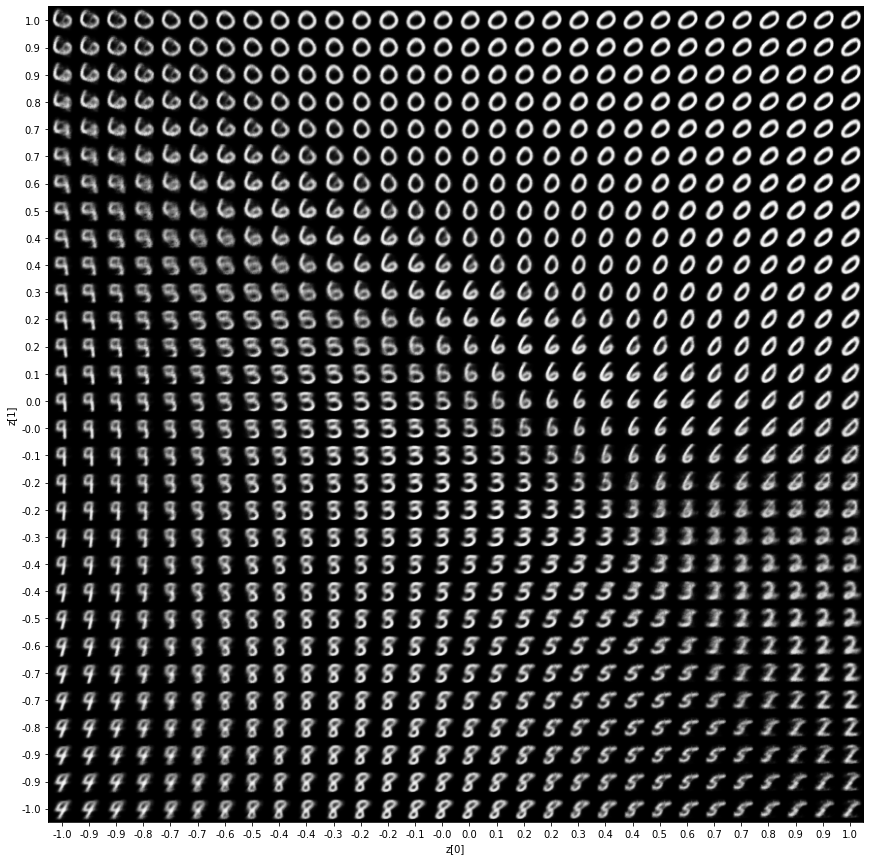

In [ ]:
plot_latent_space(vae)

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

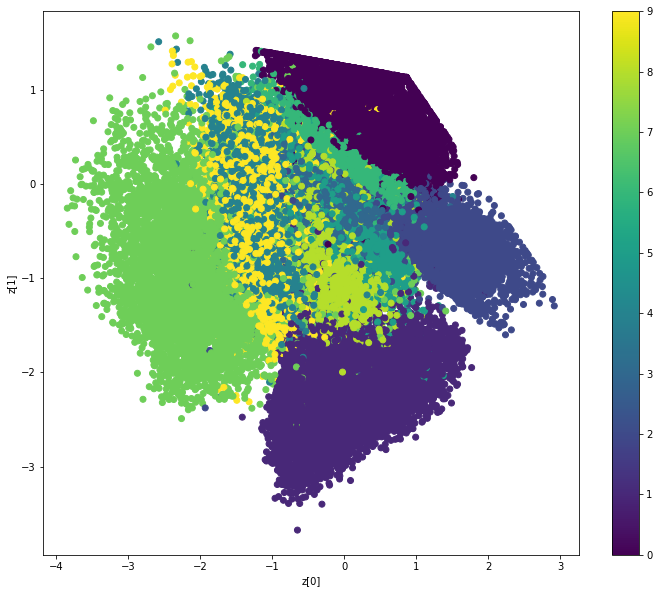

In [ ]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [ ]:
# train for another 50 epochs
vae.fit(mnist_digits, epochs=50, batch_size=128)

Epoch 1/50
547/547 [==============================] - 6s 11ms/step - loss: 149.5451 - reconstruction_loss: 143.2539 - kl_loss: 6.5586
Epoch 2/50
547/547 [==============================] - 6s 11ms/step - loss: 149.3331 - reconstruction_loss: 142.9880 - kl_loss: 6.5637
Epoch 3/50
547/547 [==============================] - 6s 11ms/step - loss: 149.6550 - reconstruction_loss: 142.9581 - kl_loss: 6.5667
Epoch 4/50
547/547 [==============================] - 6s 11ms/step - loss: 149.4101 - reconstruction_loss: 142.9729 - kl_loss: 6.5727
Epoch 5/50
547/547 [==============================] - 6s 11ms/step - loss: 148.9512 - reconstruction_loss: 142.6917 - kl_loss: 6.5914
Epoch 6/50
547/547 [==============================] - 6s 11ms/step - loss: 148.9216 - reconstruction_loss: 142.6628 - kl_loss: 6.5806
Epoch 7/50
547/547 [==============================] - 6s 11ms/step - loss: 149.1191 - reconstruction_loss: 142.6321 - kl_loss: 6.5764
Epoch 8/50
547/547 [==============================] - 6s 11ms/

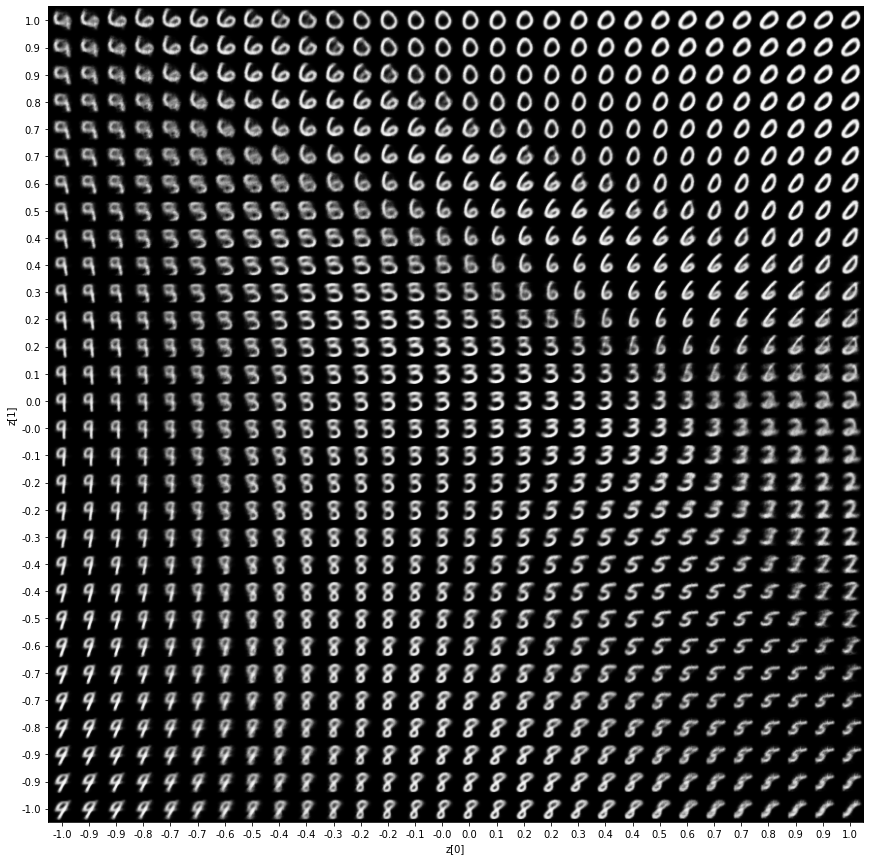

In [ ]:
plot_latent_space(vae)

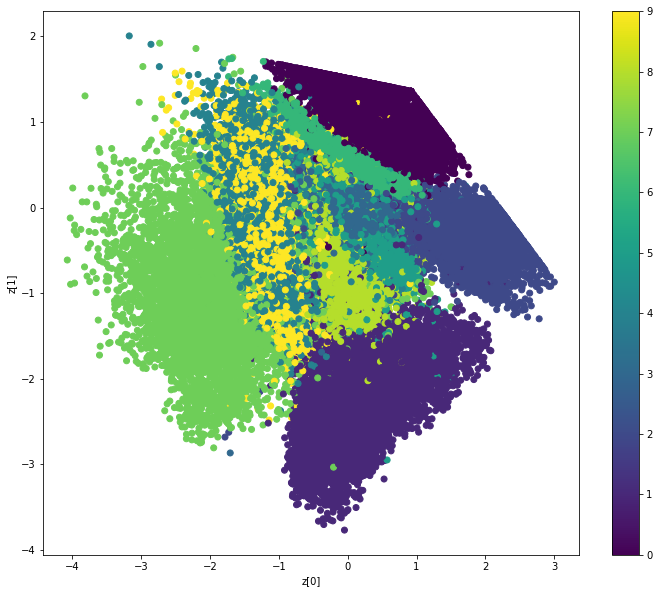

In [ ]:
plot_label_clusters(vae, x_train, y_train)